In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [9]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return np.array(result.tolist())

In [10]:
phantom_data=scipy.io.loadmat('new phantom data/Bay1.mat')

In [11]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]
cleaned = phantom_data["NoiseNet_Cleaned"]
print(gt.shape,fmri.shape,cleaned.shape)

(3712, 600) (3712, 600) (3712, 600)


In [12]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
print(gt_mean.shape)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)
gt_skew = sp.stats.skew(gt,axis=1)
fmri_skew = sp.stats.skew(fmri,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

skew_idx = np.argsort(gt_nooutliers)

(3712,)
7 49


In [13]:
# even though the data is expected to be normalized, we just want to make sure
gt_norm = (gt - gt_mean[:,np.newaxis])
fmri_norm = (fmri - fmri_mean[:,np.newaxis])
print(gt_norm.shape)

(3712, 600)


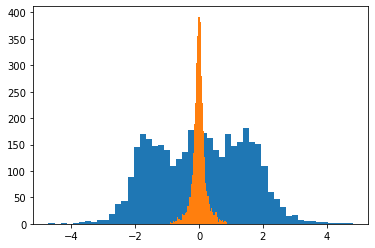

In [14]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

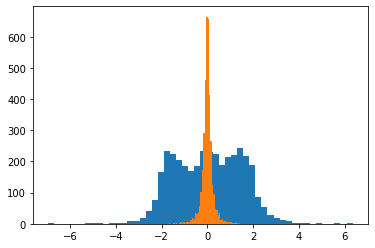

In [15]:
skew_idx = np.argsort(gt_nooutliers)
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

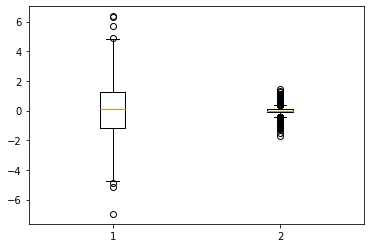

In [16]:
_ = plt.boxplot([gt_skew,fmri_skew])

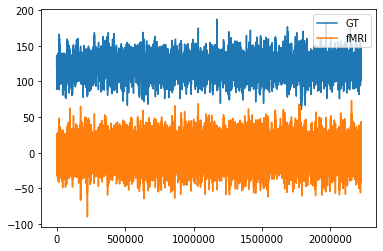

In [17]:
idx = 800
gt_data = gt_norm[skew_idx].flatten()
fmri_data = fmri_norm[skew_idx].flatten()
plt.plot(gt_data+120,label="GT")
plt.plot(fmri_data,label="fMRI")
plt.legend(loc="upper right")

In [18]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [08:06<00:00,  8.22draws/s] 
The acceptance probability does not match the target. It is 0.8913876675828273, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879819166403923, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9049640457283864, but should be close to 0.8. Try to increase the number of tuning steps.


In [19]:
#pm.traceplot(posterior_2)

In [20]:
pm.summary(posterior_2)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,7.513886,0.004228,0.000105,7.505853,7.522458,1259.925312,0.999891
ampl_noise,0.767293,0.001993,0.000050,0.763098,0.770995,1287.385170,0.999518


In [21]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/thermal:",sigma_mult**2/sig_total**2)

sigma mult: 3.610252081040079
sigma thermal: 7.513886016693291
sigma thermal normalized 1.5969382274775237
sigma thermal normalized error 0.0008985586941461639
sigma total noise fitted: 8.33621035966063
sigma total (fmri-gt): 8.282203707789558
sigma GT: 4.705182634748498
signal to noise ratio: 0.31857789656810204
sigma multi/thermal: 0.187558920052722


In [22]:
# here we assume that the two distributions add
with pm.Model() as multi_noise2:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    ampl_signal = pm.Uniform('ampl_signal',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data*ampl_signal,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*ampl_signal**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_signal, ampl_noise, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [16:35<00:00,  4.02draws/s]  
The acceptance probability does not match the target. It is 0.8998580870496798, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875713598031295, but should be close to 0.8. Try to increase the number of tuning steps.


In [23]:
#pm.traceplot(posterior['sigma1'])

In [24]:
pm.summary(posterior_2)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,7.472701,0.004023,0.000106,7.465249,7.480783,1256.181388,1.000387
ampl_noise,1.149038,0.004626,0.000147,1.140060,1.157858,1055.847351,0.999988
ampl_signal,0.603046,0.001501,0.000051,0.600113,0.605989,918.780539,0.999367


In [30]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
amp_signal = np.mean(posterior_2['ampl_signal'])
sigma_mult = amp_noise*np.std(amp_signal*gt_data)
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data*amp_signal))
print("sigma GT:",np.std(gt_data*amp_signal))
print("signal to noise ratio:",np.std(gt_data*amp_signal)**2/(sigma_mult**2+sig**2))
print("sigma multi/thermal:",sigma_mult**2/sig_total**2)

sigma mult: 3.260328857532582
sigma thermal: 7.472700661039819
sigma thermal normalized 1.588185037888386
sigma thermal normalized error 0.0008550890672328583
sigma total noise fitted: 8.15297488213748
sigma total (fmri-gt): 8.115314588699825
sigma GT: 2.837442101158302
signal to noise ratio: 0.12112165826623057
sigma multi/thermal: 0.15991551730241924


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


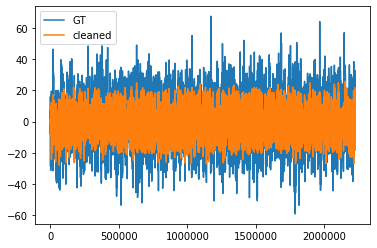

In [26]:
idx = 800
gt_data = gt[skew_idx].flatten()
cleaned_data = cleaned[skew_idx].flatten()
plt.plot(gt_data,label="GT")
plt.plot(cleaned_data,label="cleaned")
plt.legend()

In [27]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    ampl_signal = pm.Uniform('ampl_signal',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=ampl_signal*gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=cleaned_data)

    posterior_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_signal, ampl_noise, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [49:21<00:00,  1.35draws/s]  
The acceptance probability does not match the target. It is 0.9703681801103979, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9585914324810251, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9997042340027528, but should be close to 0.8. Try to increase the number of tuning steps.


In [28]:
pm.summary(posterior_3)

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,0.883713,0.000683,0.000017,0.882430,0.885026,1439.539512,0.999388
ampl_noise,0.363954,0.000371,0.000009,0.363226,0.364678,1495.800914,0.999562
ampl_signal,0.151316,0.000390,0.000012,0.150633,0.152123,1009.829273,1.001647


In [31]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_3['sigma1'])
amp_noise = np.mean(posterior_3['ampl_noise'])
amp_signal = np.mean(posterior_3['ampl_signal'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)**amp_signal**2*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(amp_signal*gt_data))
print("sigma thermal normalized error",np.std(posterior_3['sigma1'])/np.std(amp_signal*gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(cleaned_data-amp_signal*gt_data))
print("sigma GT:",np.std(amp_signal*gt_data))
print("signal to noise ratio:",np.std(amp_signal*gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/total noise:",sigma_mult**2/sig_total**2)
print("sigma thermal/total noise:",sig**2/sig_total**2)

sigma mult: 4.597545040337625
sigma thermal: 0.8837128784909198
sigma thermal normalized 1.2412244430224055
sigma thermal normalized error 0.0009586172002555281
sigma total noise fitted: 4.6817057628116485
sigma total (fmri-gt): 1.899439730439192
sigma GT: 0.7119686398851942
signal to noise ratio: 0.023126691026121853
sigma multi/total noise: 0.9643701382629594
sigma thermal/total noise: 0.03562986173704078
